<a href="https://colab.research.google.com/github/lifesboy/selks-lstm-data/blob/main/SELKS_LSTM_Anomaly_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.LSTM KERAS

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

# 2.PREPARATION

In [1]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-02-09 05:32:27.131789: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 05:32:29.566318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 12727 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-09 05:32:29.567764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 12535 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-09 05:32:29.568889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [2]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pyarrow
import pyarrow as pa
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')


2023-02-09 05:32:32,663[INFO][140263197304640-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [3]:
#@title Generate an input sequence
#10.0.2.10
#10.0.2.155
#10.0.2.180
#10.0.2.181
#10.0.2.182
#192.168.66.39
#192.168.66.21

cell_size = 320 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 230 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

# generate datasets
train_size= 56 #@param {type:"integer"}
test_size = 160  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=100 #@param {type:"integer"}

L_source = '/cic/dataset/normalized_labeled/nsm-huongftp/' #@param {type:"string"}
L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
#features = [*features, *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]]
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()'])
predict_size = total_size // n_timesteps_in
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[LABEL] = L_predict[L_predict['src_ip'] == '172.18.12.113']
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[[LABEL]].to_numpy().reshape((predict_size, n_timesteps_in))

Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 29.10it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [4]:
L_count

,label,count()
0,0.0,84648


## Data preview

### L_train preview

In [5]:
L_predict[[LABEL, *features]]

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.999329,1.0,1.0,1.0,1.0,1.0,0.999831,0.0,1.000000,0.0,1.0,0.0,0.0,0.496667,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.964028,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.000000,1.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.582783,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.999988,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,0.999988,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999329,1.0,0.999988,0.0,0.999329,0.999988,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.582783,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.999909,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,0.999909,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999329,1.0,0.999988,0.0,0.999329,0.999988,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.000000,0.0,0.999774,0.0,1.0,0.0,0.0,0.462117,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,0.761594,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.761594,1.0,0.964028,0.0,0.761594,0.964028,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.582783,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.999998,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,0.999998,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999329,1.0,0.999988,0.0,0.999329,0.999988,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.582783,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999329,1.0,0.999988,0.0,0.999329,0.999988,1.0,1.0,0.0
84596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.582783,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,0.964028,0.0,0.0,1.0,1.

In [6]:
L_predict[[LABEL, *features]].describe()

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
count,84600.0,84600.0,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.0,84600.000000,84600.0,84600.0,84600.000000,84600.0,84600.0,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.0,84600.000000,84600.000000,84600.0,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.000000,84600.0,84600.0,84600.0,84600.000000,84600.000000,84600.0,84600.000000,84600.0,84600.0,84600.0,84600.000000,84600.000000,84600.000000,84600.000000,84600.0,84600.000000,84600.000000,84600.000000,84600.000000,84600.0
mean,0.0,0.0,0.089894,0.089894,0.089890,0.089894,0.156312,0.156312,0.705437,0.554870,0.554870,0.379445,0.554818,0.554870,0.705437,0.705437,0.705437,0.533460,0.156231,0.652199,0.0,0.705437,0.0,0.0,0.533503,1.0,0.0,0.702080,0.984361,0.984361,0.881277,0.881087,0.617106,0.881262,0.942936,0.886374,0.162766,0.162766,0.999976,0.798617,0.798617,0.754333,0.798597,0.798617,0.999976,0.999976,0.999976,0.858867,0.162727,0.917234,0.0,0.999976,0.999976,0.0,0.160319,0.160319,0.160319,0.160319,0.618239,0.918522,1.0,1.0,1.0,0.945037,0.944989,1.0,0.999989,0.0,0.0,1.0,0.705437,0.681840,0.999976,0.974045,0.0,0.681840,0.974045,0.705437,0.999976,0.0
std,0.0,0.0,0.286031,0.286031,0.286021,0.286031,0.363153,0.363153,0.455849,0.496983,0.496983,0.637236,0.496979,0.496983,0.455849,0.455849,0.455849,0.491252,0.362964,0.455198,0.0,0.455849,0.0,0.0,0.374595,0.0,0.0,0.204412,0.124072,0.124072,0.323465,0.323979,0.702078,0.323466,0.172111,0.250469,0.369154,0.369154,0.004862,0.401036,0.401036,0.474028,0.401036,0.401036,0.004862,0.004862,0.004862,0.347204,0.369066,0.200906,0.0,0.004862,0.004862,0.0,0.366904,0.366904,0.366904,0.366903,0.485821,0.273569,0.0,0.0,0.0,0.227727,0.227886,0.0,0.000003,0.0,0.0,0.0,0.455849,0.445526,0.004862,0.068377,0.0,0.445526,0.068377,0.455849,0.004862,0.0
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,1.0,0.999988,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0

In [7]:
DataFrame.from_records(LX_predict[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.999329,1.0,1.0,1.0,1.0,1.0,0.999831,0.000000,1.000000,0.0,1.0,0.0,0.0,0.496667,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.964028,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.000000,1.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.582783,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.999988,1.0,1.0,0.964028,0.0,0.0,1.0,1.0,1.0,0.999988,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999329,1.0,0.999988,0.0,0.999329,0.999988,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.582783,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.999909,1.0,1.0,0.964028,0.0,0.0,1.0,1.0,1.0,0.999909,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999329,1.0,0.999988,0.0,0.999329,0.999988,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.000000,0.000000,0.999774,0.0,1.0,0.0,0.0,0.462117,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.761594,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.761594,1.0,0.964028,0.0,0.761594,0.964028,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.582783,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.999998,1.0,1.0,0.964028,0.0,0.0,1.0,1.0,1.0,0.999998,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999329,1.0,0.999988,0.0,0.999329,0.999988,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,-1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.999329,1.000000,0.0,1.0,0.0,0.0,0.964028,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,-1.000000,1.0,1.0,0.995055,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.999909,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.000000,1.0,0.999909,0.0,1.000000,0.999909,1.0,1.0,0.0
96,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,-1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.999329,1.000000,0.0,1.0,0.0,0.0,0.964028,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,-1.000000,1.0,1.0,0.995055,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.999905,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.000000,1.0,0.999909,0.0,1.000000,0.999909,1.0,1.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.992632,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,-1.000000,1.0,1.0,0.999329,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.999935,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.000000,1.0,0.999909,0.0,1.000000,0.999909,1.0,1.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.921669,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.995055,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.

In [8]:
DataFrame.from_records(LX_predict[0]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
count,100.0,100.00000,100.00000,100.00000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.0,100.000000,100.0,100.0,100.000000,100.00,100.00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.0,100.0,1.000000e+02,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.0,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.000000,100.0,100.0
mean,0.0,0.21000,0.21000,0.21000,0.21000,0.050000,0.050000,0.500000,0.300000,0.300000,0.209942,0.300000,0.300000,0.500000,0.500000,0.500000,0.309991,0.049980,0.432611,0.0,0.500000,0.0,0.0,0.337700,1.0,0.0,0.708283,0.99,0.99,0.890000,0.890000,0.770735,0.890000,0.745653,0.874275,0.120000,0.120000,1.000000e+00,0.770000,0.770000,0.768712,0.770000,0.770000,1.0,1.0,1.0,0.873933,0.119982,0.727539,0.0,1.0,1.000000e+00,0.0,0.480000,0.480000,0.480000,0.480000,0.420000,0.970000,1.0,1.0,1.0,0.949999,0.950000,1.0,0.999988,0.0,0.0,1.0,0.500000,0.458304,1.0,0.977315,0.0,0.458304,0.977315,0.500000,1.0,0.0
std,0.0,0.40936,0.40936,0.40936,0.40936,0.219043,0.219043,0.502519,0.460566,0.460566,0.498289,0.460566,0.460566,0.502519,0.502519,0.502519,0.464810,0.218955,0.485169,0.0,0.502519,0.0,0.0,0.368616,0.0,0.0,0.195297,0.10,0.10,0.314466,0.314466,0.539849,0.314466,0.302464,0.258833,0.326599,0.326599,3.858754e-08,0.422953,0.422953,0.422290,0.422953,0.422953,0.0,0.0,0.0,0.329964,0.326550,0.319275,0.0,0.0,3.858754e-08,0.0,0.502117,0.502117,0.502117,0.502117,0.496045,0.171447,0.0,0.0,0.0,0.219043,0.219043,0.0,0.000002,0.0,0.0,0.0,0.502519,0.467388,0.0,0.060903,0.0,0.467388,0.060903,0.502519,0.0,0.0
min,0.0,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.999998e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,1.0,9.999998e-01,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,1.0,0.999988,0.0,0.0,1.0,0.000000,0.000000,1.0,0.761594,0.0,0.000000,0.761594,0.000000,1.0,0.0
25%,0.0,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.761594,1.00,1.00,1.000000,1.000000,0.998261,1.000000,0.532996,0.761594,0.000000,0.000000,1.000000e+00,1.000000,1.000000,0.964028,1.000000,1.000000,1.0,1.0,1.0,1.000000,0.000000,0.521396,0.0,1.0,1.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.0,0.999988,0.0,0.0,1.0,0.000000,0.000000,1.0,0.995055,0.0,0.000000,0.995055,0.000000,1.0,0.0
50%,0.0,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.000000,0.000000,0.008718,0.0,0.500000,0.0,0.0,0.038386,1.0,0.0,0.761594,1.00,1.00,1.000000,1.000000,1.000000,1.000000,0.979617,0.999619,0.000000,0.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,0.000000,0.979617,0.0,1.0,1.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.0,0.999988,0.0,0.0,1.0,0.500000,0.380797,1.0,0.999988,0.0,0.380797,0.999988,0.500000,1.0,0.0
75%,0.0,0.00000,0.00000,0.00000,0.000

In [9]:
DataFrame.from_records(Ly_predict)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [10]:
DataFrame.from_records(Ly_predict).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0,846.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data visualization

In [11]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

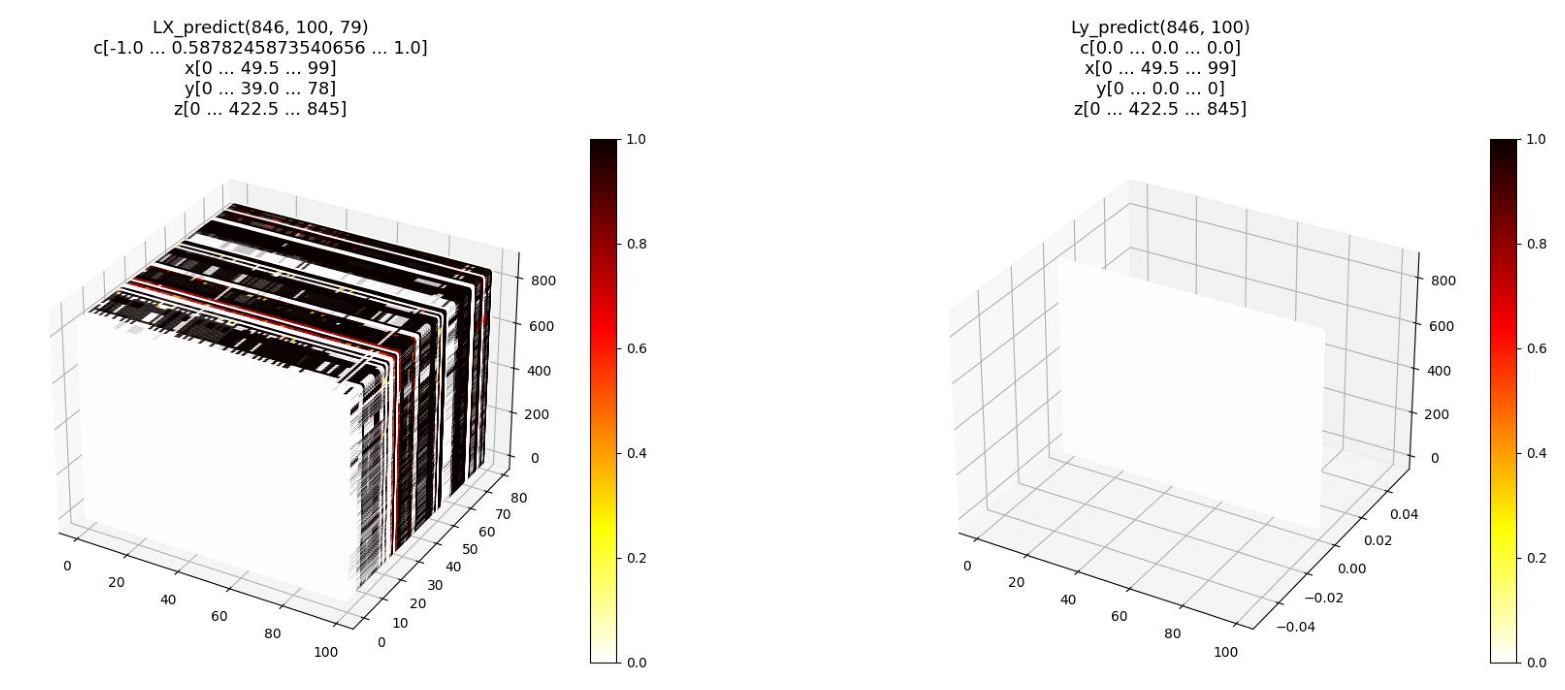

In [12]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])

# 4.INTRODUCTION

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [21]:
def threshold(num):
    return 1 if num > 0.5 else 0

def infer(name='model', checkpoint='anomaly_flow79_local_ftp_norm'):
    model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
    Ly_predict_predicted=model.predict(LX_predict)
    predicted = np.vectorize(threshold)(Ly_predict_predicted)
    print(f"predicted/Ly_predict = {predicted.sum()}/{Ly_predict.sum()}")
    #np.logical_and(predicted.reshape((56,100)), Ly_predict).sum()

    [IMG['Ly_predict_predicted']] = ray.get([
        show_scattered_4d.remote(Ly_predict_predicted, "Ly_predict_predicted"),
    ])
    show_4d_imgs(['LX_predict','Ly_predict','Ly_predict_predicted'])

___

# 6.LSTM Anomaly model (Primary)

## 6.3.Infer



predicted/Ly_predict = 25776/0.0


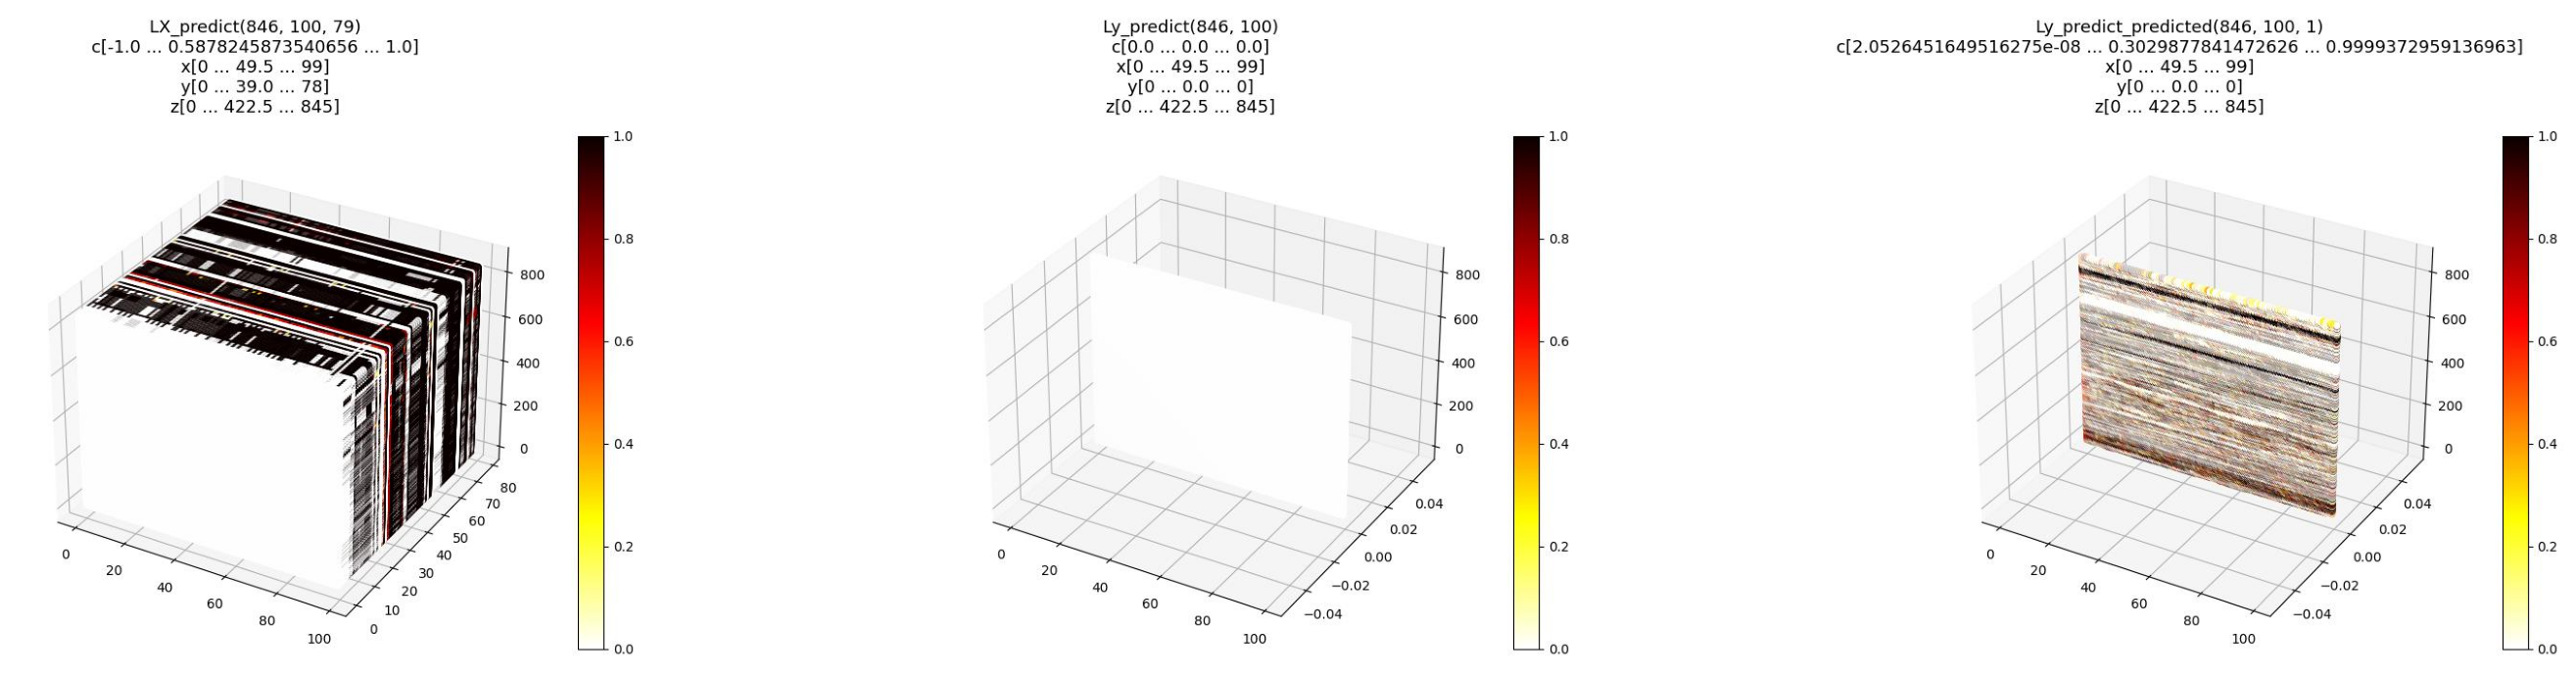

In [22]:
infer('model6')

In [23]:
infer('model6', 'anomaly_flow79_cic_ftp_norm')

OSError: No file or directory found at /usr/local/opnsense/scripts/ml/aicheckpoints/anomaly_flow79_cic_ftp_norm/model6

(raylet) [2023-02-09 05:49:30,507 E 14275 14275] (raylet) worker_pool.cc:1099: Failed to send exit request: GrpcUnavailable: RPC Error message: Connection timed out; RPC Error details: 
(raylet) [2023-02-09 05:49:30,514 E 14275 14275] (raylet) worker_pool.cc:1099: Failed to send exit request: GrpcUnavailable: RPC Error message: Connection timed out; RPC Error details: 
